In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
import torch

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from data_modules.inrmorph import load_data
from config import get_datapath

### Evaluating Optimal Regularization Combination

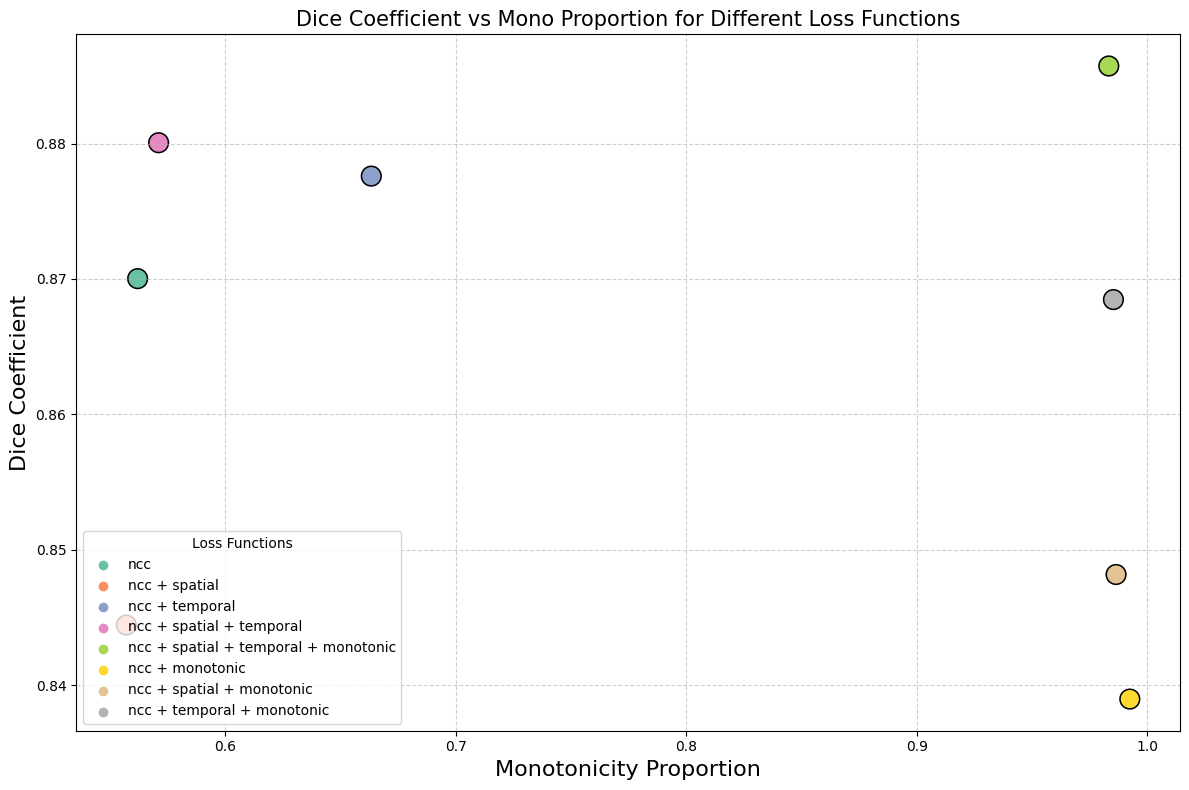

In [3]:
data = pd.read_csv('evaluating_optimal_regularization_combination.csv')
palette = sns.color_palette("Set2", n_colors=len(data['loss_functions'].unique()))
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=data,
    x='mono_proportion',
    y='dice',
    hue='loss_functions',
    palette=palette, 
    s=200,  
    edgecolor='black', 
    legend='full'
)
plt.title('Dice Coefficient vs Mono Proportion for Different Loss Functions', fontsize=15)
plt.xlabel('Monotonicity Proportion', fontsize=16)
plt.ylabel('Dice Coefficient', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Loss Functions', loc='lower left', fontsize=10)
plt.tight_layout()
plt.show()


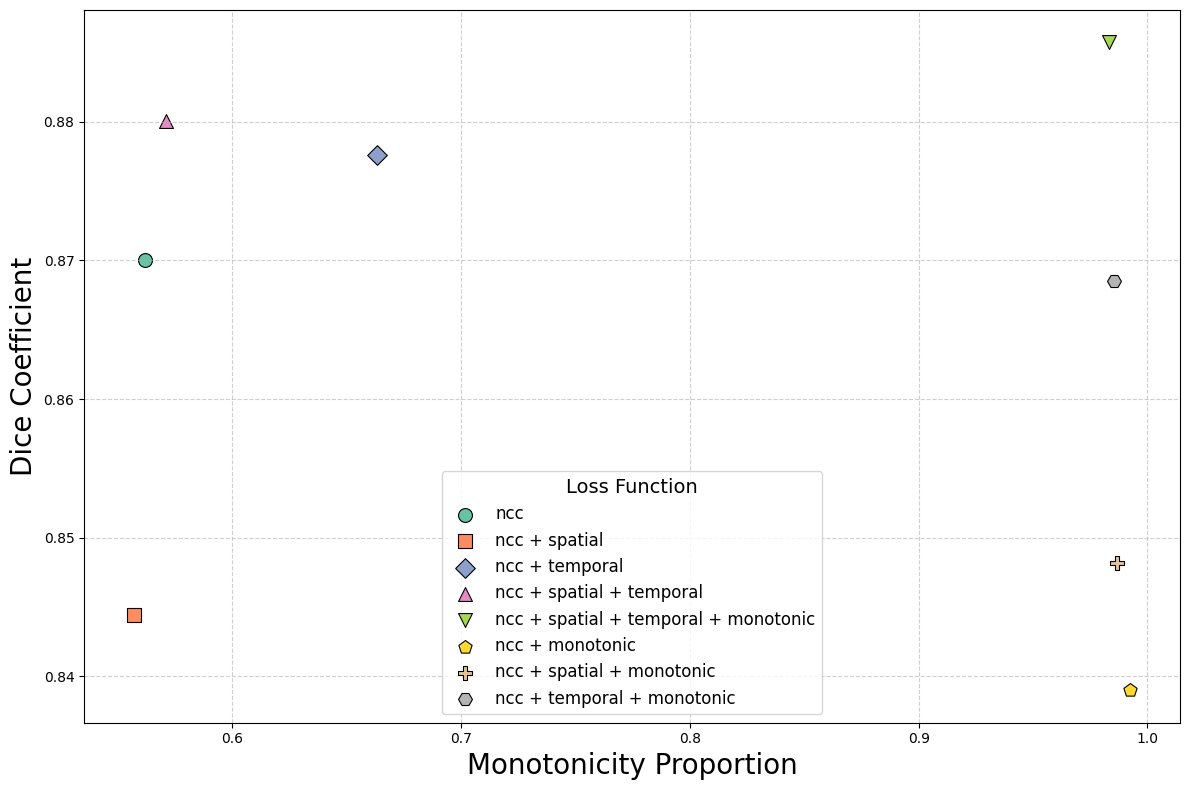

In [4]:
markers = ['o', 's', 'D', '^', 'v', 'p', 'P', 'H', 'X', '*', 'd', '>']
plt.figure(figsize=(12, 8))

#plot model type separately with different markers
for i, loss_functions in enumerate(data['loss_functions'].unique()):
    subset = data[data['loss_functions'] == loss_functions]
    sns.scatterplot(
        x=subset['mono_proportion'],
        y=subset['dice'],
        label=loss_functions,
        color=palette[i], 
        marker=markers[i], 
        s=100, 
        edgecolor='black'
    )
# plt.title('Dice Coefficient vs Mono Proportion for Different Loss Functions', fontsize=15)
plt.xlabel('Monotonicity Proportion', fontsize=20)
plt.ylabel('Dice Coefficient', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Loss Function', loc='lower center', fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()


### AD vs MCI vs CN

In [ ]:

group_jacobian_metrics = "group_jacobian_metrics.csv"
df = pd.read_csv(group_jacobian_metrics)

ventricles_df = df[df["structure"].str.contains("ventricle", case=False)]

grouped = ventricles_df.groupby(["time_point", "group"])["jac_det_mean"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=grouped,
    x="time_point",
    y="jac_det_mean",
    hue="group",
)
plt.title("Mean Jacobian Determinant for Ventricles Over Time", fontsize=14)
plt.xlabel("Time Point", fontsize=12)
plt.ylabel("Mean Jacobian Determinant", fontsize=12)
plt.legend(title="Group", fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()


#specific subjects
ad_subjects = ["005_S_0814"]  #005_S_0814, 007_S_4568,153_S_4172, 016_S_4591, 
mci_subjects = ["003_S_1122"] #116_S_0361, 009_S_1030, 003_S_1122, 141_S_1052
cn_subjects = ["002_S_4270"] #099_S_4104, 098_S_4506, 023_S_0061, 002_S_4270

ventricles_df = df[df["structure"].str.contains("ventricle", case=False, na=False)]
specific_subjects = ad_subjects + mci_subjects + cn_subjects
filtered_df = ventricles_df[ventricles_df["subjectID"].isin(specific_subjects)]

grouped = filtered_df.groupby(["time_point", "group", "subjectID"], as_index=False)["jac_det_mean"].mean()

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=grouped,
    x="time_point",
    y="jac_det_mean",
    hue="group",
    style="group", 
    dashes=True 
)
plt.title("Mean Jacobian Determinant for Ventricle Structures Across Time")
plt.xlabel("Time Point")
plt.ylabel("Mean Jacobian Determinant")
plt.legend(title="Group", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [89]:
ventricles_cn_df = df[(df["structure"].str.contains("ventricle", case=False)) & (df["group"] == "AD")]
subject_means = ventricles_cn_df.groupby("subjectID")["jac_det_mean"].mean().reset_index()
subject_means.rename(columns={"jac_det_mean": "mean_jac_det"}, inplace=True)
sorted_subjects = subject_means.sort_values(by="mean_jac_det", ascending=False)
second_min_row = sorted_subjects.iloc[8]
subject_id = second_min_row["subjectID"]
print(f"Subject ID with the second minimum mean jac_det_mean: {subject_id}")



Subject ID with the second minimum mean jac_det_mean: 016_S_4591


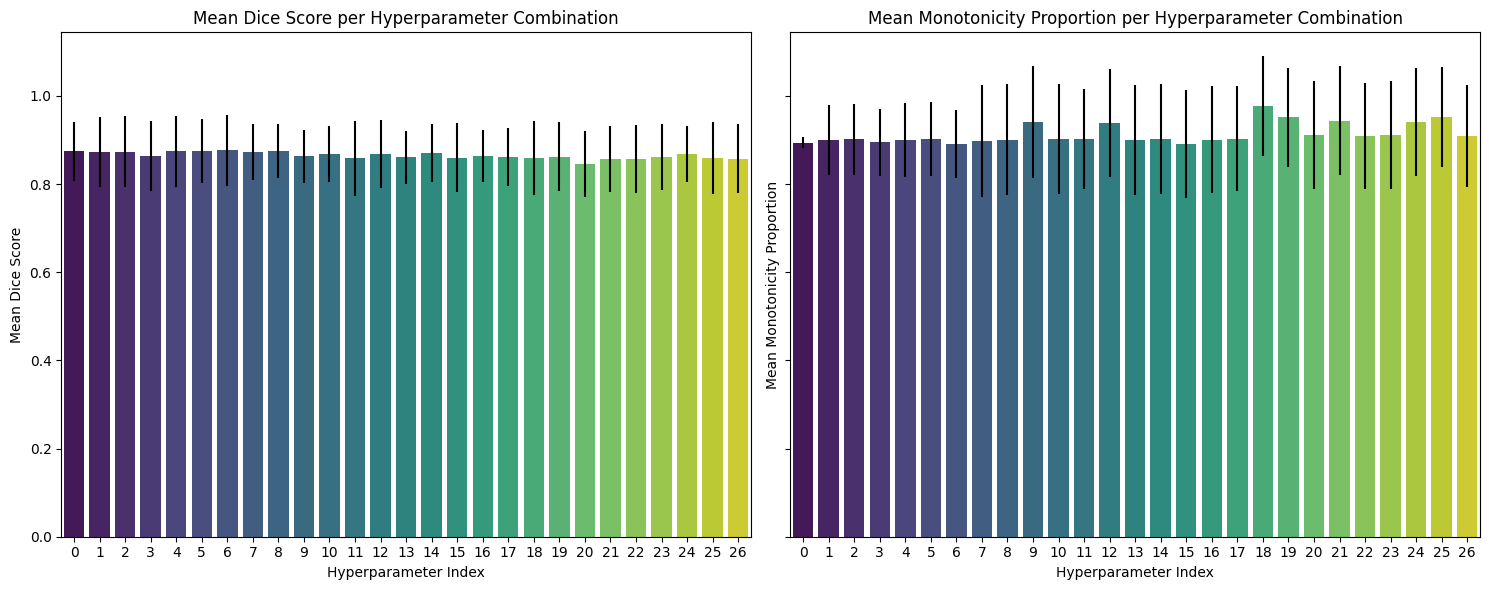

In [14]:
#cross val results
df = pd.read_csv("cross_val_results.csv")

agg_df = df.groupby('hyperparam_idx').agg({
    'structure_dice': ['mean', 'std'],
    'total_proportion_monotonicity': ['mean', 'std']
}).reset_index()

agg_df.columns = ['hyperparam_idx', 'dice_mean', 'dice_std', 'monotonicity_mean', 'monotonicity_std']

agg_df['combined_score'] = agg_df['dice_mean'] + agg_df['monotonicity_mean']
agg_df.sort_values(by='combined_score', ascending=False, inplace=True)

# print("Top hyperparameter combinations:")
# print(agg_df.head(50))
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.barplot(ax=axes[0], data=agg_df, x='hyperparam_idx', y='dice_mean', yerr=agg_df['dice_std'], palette='viridis')
axes[0].set_title('Mean Dice Score per Hyperparameter Combination')
axes[0].set_xlabel('Hyperparameter Index')
axes[0].set_ylabel('Mean Dice Score')

sns.barplot(ax=axes[1], data=agg_df, x='hyperparam_idx', y='monotonicity_mean', yerr=agg_df['monotonicity_std'], palette='viridis')
axes[1].set_title('Mean Monotonicity Proportion per Hyperparameter Combination')
axes[1].set_xlabel('Hyperparameter Index')
axes[1].set_ylabel('Mean Monotonicity Proportion')
plt.tight_layout()
plt.show()


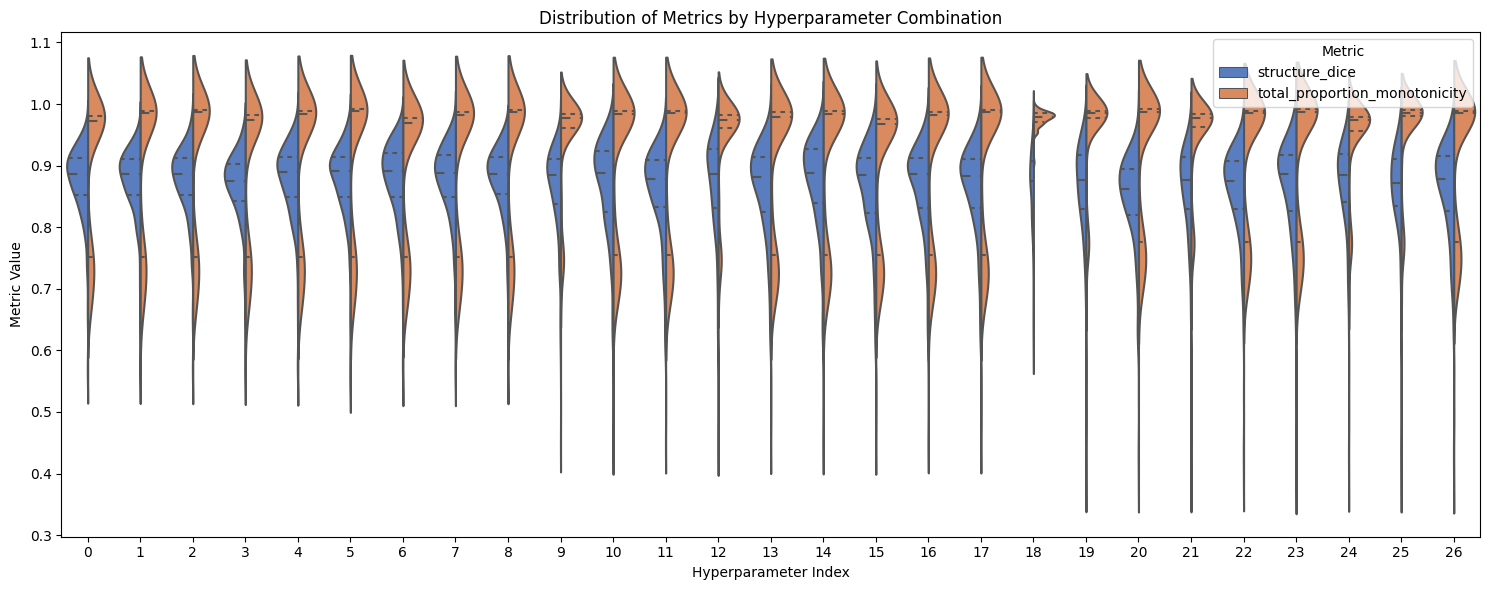

In [15]:
metrics_to_plot = ['structure_dice', 'total_proportion_monotonicity']
melted_df = df.melt(
    id_vars=['hyperparam_idx'], 
    value_vars=metrics_to_plot, 
    var_name='Metric', 
    value_name='Value'
)
plt.figure(figsize=(15, 6))

sns.violinplot(
    data=melted_df,
    x='hyperparam_idx',
    y='Value',
    hue='Metric',
    split=True, 
    inner='quartile',
    palette='muted'
)

plt.title('Distribution of Metrics by Hyperparameter Combination')
plt.xlabel('Hyperparameter Index')
plt.ylabel('Metric Value')
plt.legend(title='Metric', loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
agg_df = df.groupby(['hyperparam_idx', 'spatial_reg', 'temporal_reg', 'monotonicity_reg']).agg({
    'structure_dice': ['mean', 'std'],
    'total_proportion_monotonicity': ['mean', 'std']
}).reset_index()

agg_df.columns = [
    'hyperparam_idx', 'spatial_reg', 'temporal_reg', 'monotonicity_reg',
    'dice_mean', 'dice_std', 'monotonicity_mean', 'monotonicity_std'
]
highest_dice_idx = agg_df['dice_mean'].idxmax()
highest_monotonicity_idx = agg_df['monotonicity_mean'].idxmax()

highest_dice = agg_df.iloc[highest_dice_idx]
highest_monotonicity = agg_df.iloc[highest_monotonicity_idx]
agg_df['combined_score'] = agg_df['dice_mean'] + agg_df['monotonicity_mean']
best_combination_idx = agg_df['combined_score'].idxmax()
best_combination = agg_df.iloc[best_combination_idx]

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

sns.barplot(
    ax=axes[0],
    data=agg_df,
    x='hyperparam_idx',
    y='dice_mean',
    yerr=agg_df['dice_std'],
    palette='viridis'
)
axes[0].scatter(
    highest_dice['hyperparam_idx'], highest_dice['dice_mean'],
    color='red', s=100, label=(
        f"Best Dice\nSpatial: {highest_dice['spatial_reg']}, "
        f"Temporal: {highest_dice['temporal_reg']}, "
        f"Monotonicity: {highest_dice['monotonicity_reg']}"
    )
)
axes[0].set_title('Mean Dice Score per Hyperparameter Combination')
axes[0].set_xlabel('Hyperparameter Index')
axes[0].set_ylabel('Mean Dice Score')
axes[0].legend(loc='lower right', fontsize=9)

sns.barplot(
    ax=axes[1],
    data=agg_df,
    x='hyperparam_idx',
    y='monotonicity_mean',
    yerr=agg_df['monotonicity_std'],
    palette='viridis'
)
axes[1].scatter(
    highest_monotonicity['hyperparam_idx'], highest_monotonicity['monotonicity_mean'],
    color='red', s=100, label=(
        f"Best Monotonicity\nSpatial: {highest_monotonicity['spatial_reg']}, "
        f"Temporal: {highest_monotonicity['temporal_reg']}, "
        f"Monotonicity: {highest_monotonicity['monotonicity_reg']}"
    )
)
axes[1].set_title('Mean Monotonicity Proportion per Hyperparameter Combination')
axes[1].set_xlabel('Hyperparameter Index')
axes[1].legend(loc='lower right', fontsize=9)

sns.barplot(
    ax=axes[2],
    data=agg_df,
    x='hyperparam_idx',
    y='combined_score',
    palette='viridis'
)
axes[2].scatter(
    best_combination['hyperparam_idx'], best_combination['combined_score'],
    color='red', s=100, label=(
        f"Best Combination\nSpatial: {best_combination['spatial_reg']}, "
        f"Temporal: {best_combination['temporal_reg']}, "
        f"Monotonicity: {best_combination['monotonicity_reg']}"
    )
)
axes[2].set_title('Combined Metric Score per Hyperparameter Combination')
axes[2].set_xlabel('Hyperparameter Index')
axes[2].set_ylabel('Combined Score (Dice + Monotonicity)')
axes[2].legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()


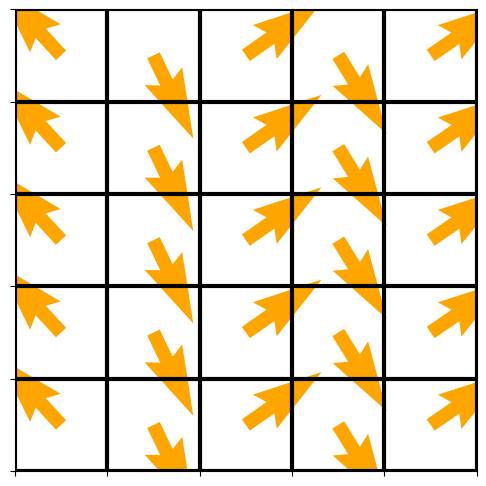

In [90]:
#plotting random displacement field for figure illustration
x = np.arange(0.5, 5) 
y = np.arange(0.5, 5)
X, Y = np.meshgrid(x, y)
U = np.zeros_like(X) 
V = np.zeros_like(Y)
for col in range(X.shape[1]):
    angle = np.random.uniform(0, 2 * np.pi)
    U[:, col] = np.cos(angle) 
    V[:, col] = np.sin(angle)  

plt.figure(figsize=(6, 6))
plt.quiver(
    X, Y, U, V, color="orange", angles="xy", scale_units="xy", scale=1.0, width=0.030
)
plt.grid(True, color="black", linestyle="-", linewidth=3) 
plt.gca().set_xticks(range(0, 6)) 
plt.gca().set_yticks(range(0, 6))  
plt.gca().set_xticklabels([]) 
plt.gca().set_yticklabels([]) 
plt.gca().set_aspect("equal")
plt.show()



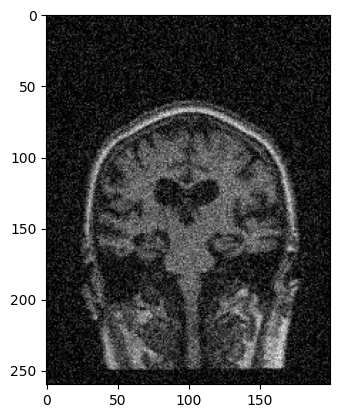

In [21]:
import nibabel as nib
data = nib.load("noisy_data_l2_100_rand/std_0.2_AD_005_S_0814/I1_2007_10_11.nii").get_fdata()
data = data[:, 150, :]
plt.imshow(data, cmap='gray')

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


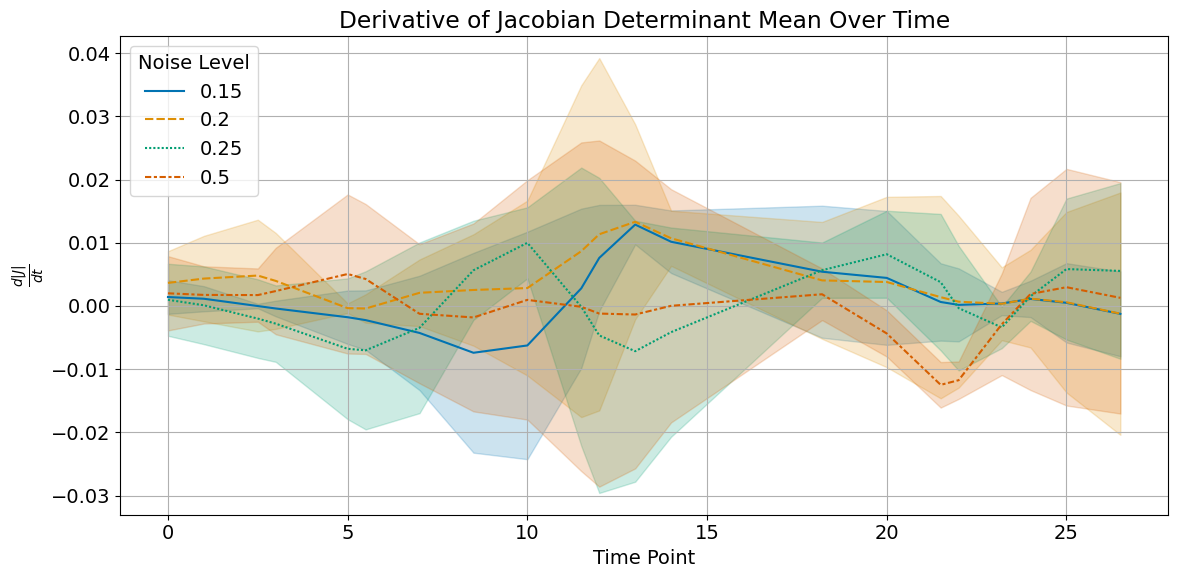

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2

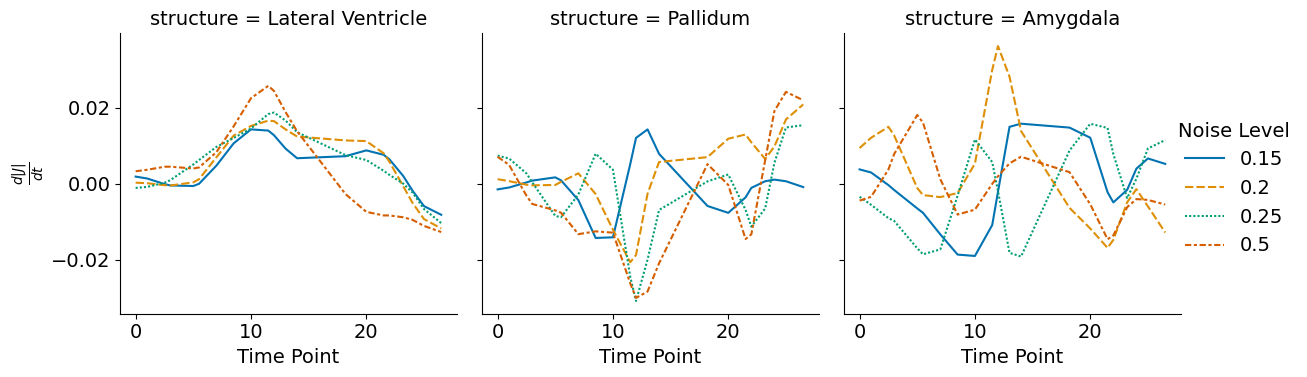

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


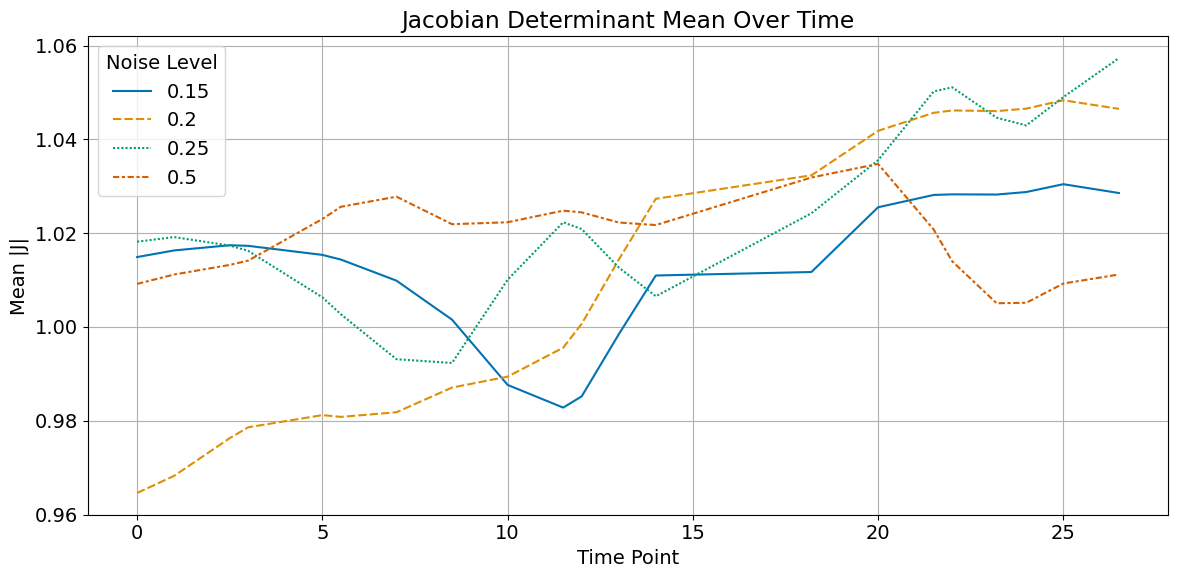

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2

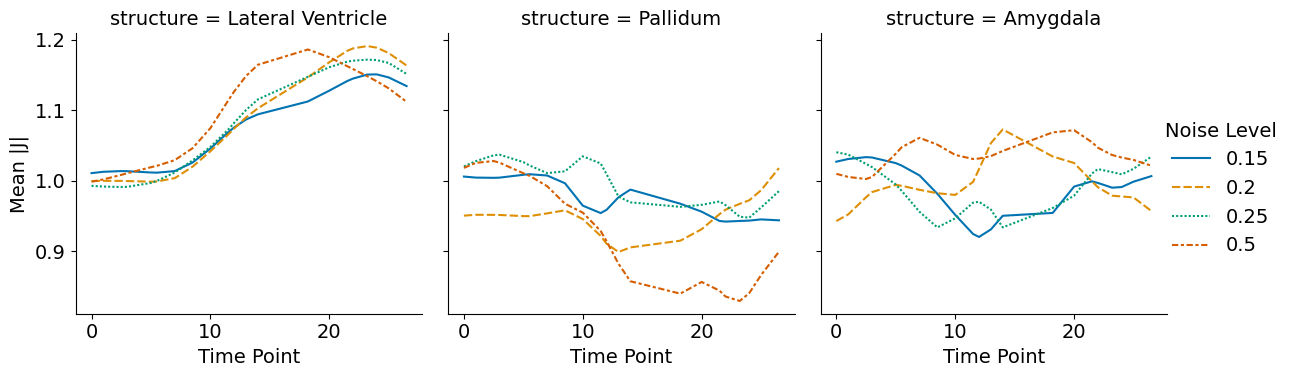

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("jacobian_metrics_nomonolossl2_10.csv")
df = df[(df["noise_level"] != 0.0) & (df["noise_level"] != 0.1)]
#im unable to plot x axis so just filter for now
structures_to_plot = ["Pallidum", "Lateral Ventricle", "Amygdala"]
df = df[df["structure"].isin(structures_to_plot)]

df["time_point"] = pd.to_numeric(df["time_point"])

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df,
    x="time_point",
    y="jac_det_derivative_mean",
    hue="noise_level",
    style="noise_level",
    markers=False,
    errorbar='sd',
    palette="colorblind"
)
plt.xlabel("Time Point")
plt.ylabel(r"$\frac{d|J|}{dt}$")
plt.title("Derivative of Jacobian Determinant Mean Over Time")
plt.legend(title="Noise Level")
plt.grid(True)
plt.tight_layout()
plt.show()

g = sns.FacetGrid(df, col="structure", col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x="time_point", y="jac_det_derivative_mean", hue="noise_level", style="noise_level", markers=False, errorbar="sd", palette="colorblind")
g.set_axis_labels("Time Point", r"$\frac{d|J|}{dt}$")
g.add_legend()
g._legend.set_title("Noise Level")
plt.show()


plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 14}) 
sns.lineplot(
    data=df,
    x="time_point",
    y="jac_det_mean",
    hue="noise_level",
    style="noise_level",
    markers=False,
    errorbar=None,
    palette="colorblind"
)
plt.xlabel("Time Point")
plt.ylabel("Mean |J|")
plt.title("Jacobian Determinant Mean Over Time")
plt.legend(title="Noise Level")
plt.grid(True)
plt.tight_layout()
plt.show()

g = sns.FacetGrid(df, col="structure", col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x="time_point", y="jac_det_mean", hue="noise_level", style="noise_level", markers=False, errorbar="sd", palette="colorblind")
g.set_axis_labels("Time Point", "Mean |J|")
g.add_legend()
g._legend.set_title("Noise Level")
plt.show()


/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


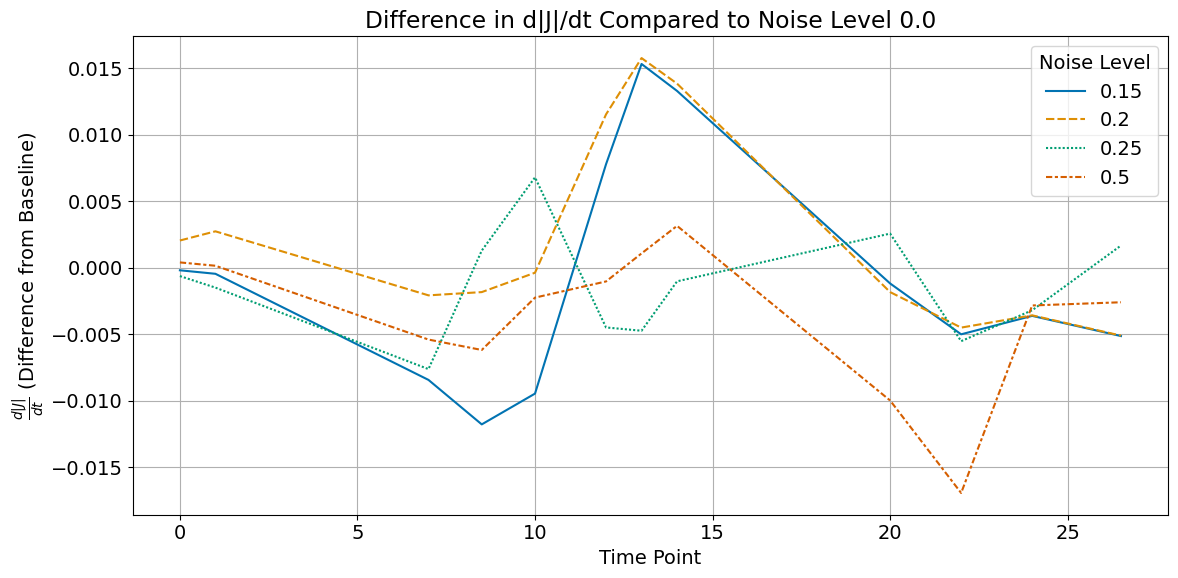

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2

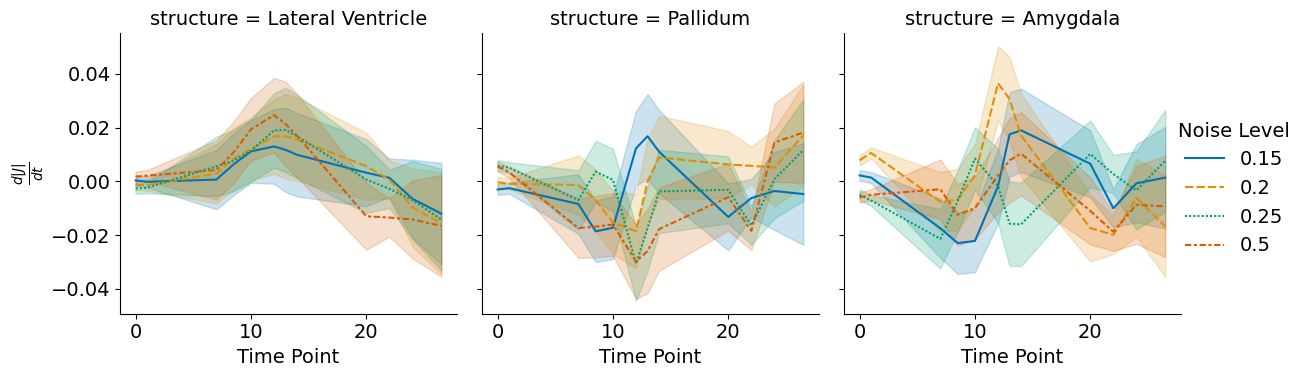

In [32]:
df = pd.read_csv("jacobian_metrics_nomonolossl2_10.csv")
df["time_point"] = pd.to_numeric(df["time_point"])
#im unable to plot x axis so just filter for now
structures_to_plot = ["Pallidum", "Lateral Ventricle", "Amygdala"]
df = df[df["structure"].isin(structures_to_plot)]
baseline_df = df[df["noise_level"] == 0.0][["time_point", "jac_det_derivative_mean"]].rename(
    columns={"jac_det_derivative_mean": "baseline_jac_det_derivative_mean"}
)
df = df.merge(baseline_df, on="time_point", how="left")

df["delta_jac_det_derivative_mean"] = df["jac_det_derivative_mean"] - df["baseline_jac_det_derivative_mean"]

df = df[(df["noise_level"] != 0.0) & (df["noise_level"] != 0.1)]
plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 14}) 
sns.lineplot(
    data=df,
    x="time_point",
    y="delta_jac_det_derivative_mean",
    hue="noise_level",
    style="noise_level",
    markers=False,
    # errorbar='sd',
    errorbar=None,
    palette="colorblind"
)

plt.xlabel("Time Point")
plt.ylabel(r"$\frac{d|J|}{dt}$ (Difference from Baseline)")
plt.title("Difference in d|J|/dt Compared to Noise Level 0.0")
plt.legend(title="Noise Level")
plt.grid(True)
plt.tight_layout()

plt.show()

#facetgrid
g = sns.FacetGrid(df, col="structure", col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x="time_point", y="delta_jac_det_derivative_mean", hue="noise_level", style="noise_level", markers=False, errorbar="sd", palette="colorblind")
g.set_axis_labels("Time Point", r"$\frac{d|J|}{dt}$")
g.add_legend()
g._legend.set_title("Noise Level")

plt.show()


/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2

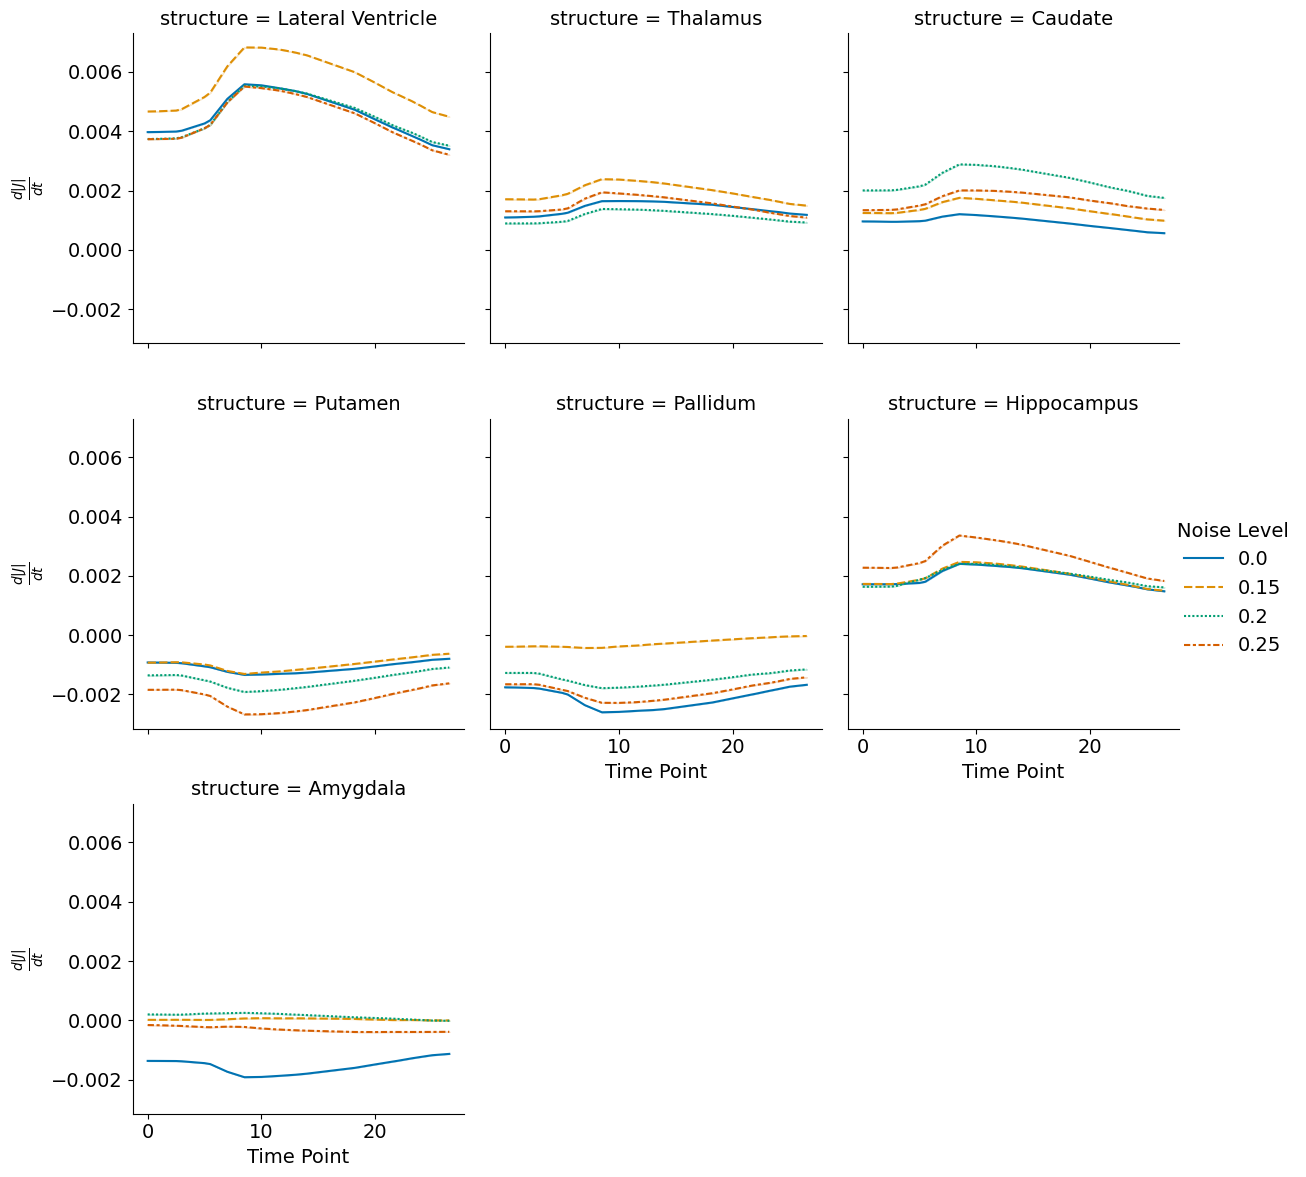

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2

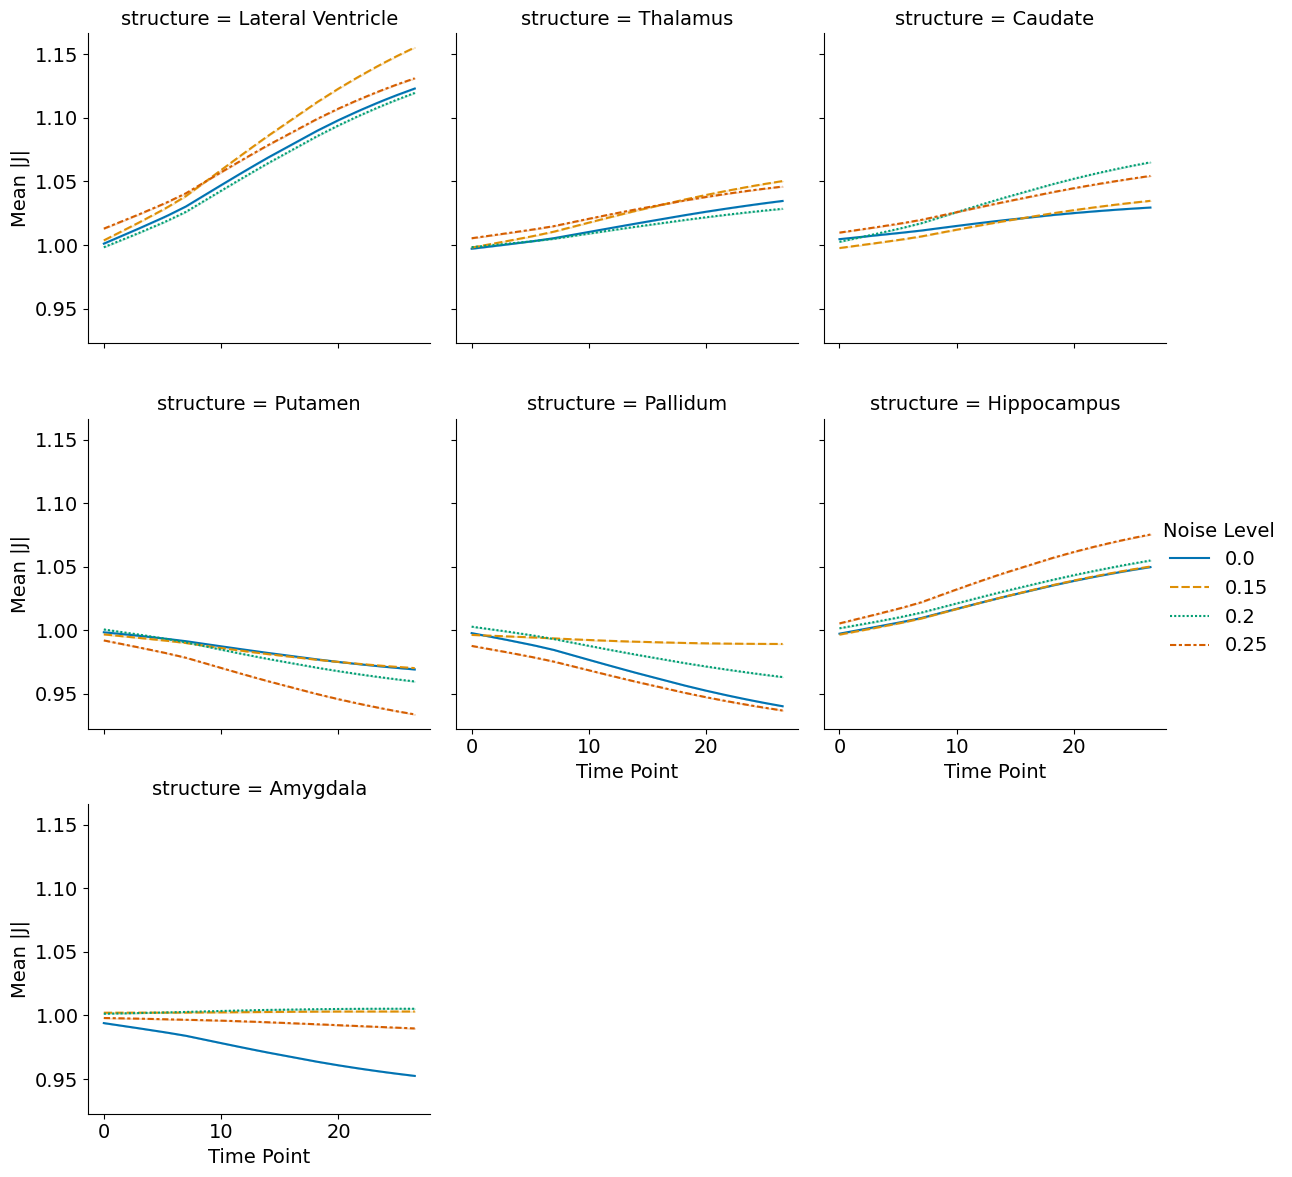

In [5]:
#with mono
plt.rcParams.update({'font.size': 14}) 
df = pd.read_csv("jacobian_metrics_withmonoloss_final.csv")
# df = df[(df["noise_level"] != 0.0)]

g = sns.FacetGrid(df, col="structure", col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x="time_point", y="jac_det_derivative_mean", hue="noise_level", style="noise_level", markers=False, errorbar="sd", palette="colorblind")
g.set_axis_labels("Time Point", r"$\frac{d|J|}{dt}$")
g.add_legend()
g._legend.set_title("Noise Level")
plt.show()


g = sns.FacetGrid(df, col="structure", col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x="time_point", y="jac_det_mean", hue="noise_level", style="noise_level", markers=False, errorbar="sd", palette="colorblind")
g.set_axis_labels("Time Point", "Mean |J|")

g.add_legend()
g._legend.set_title("Noise Level")
plt.show()


/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2

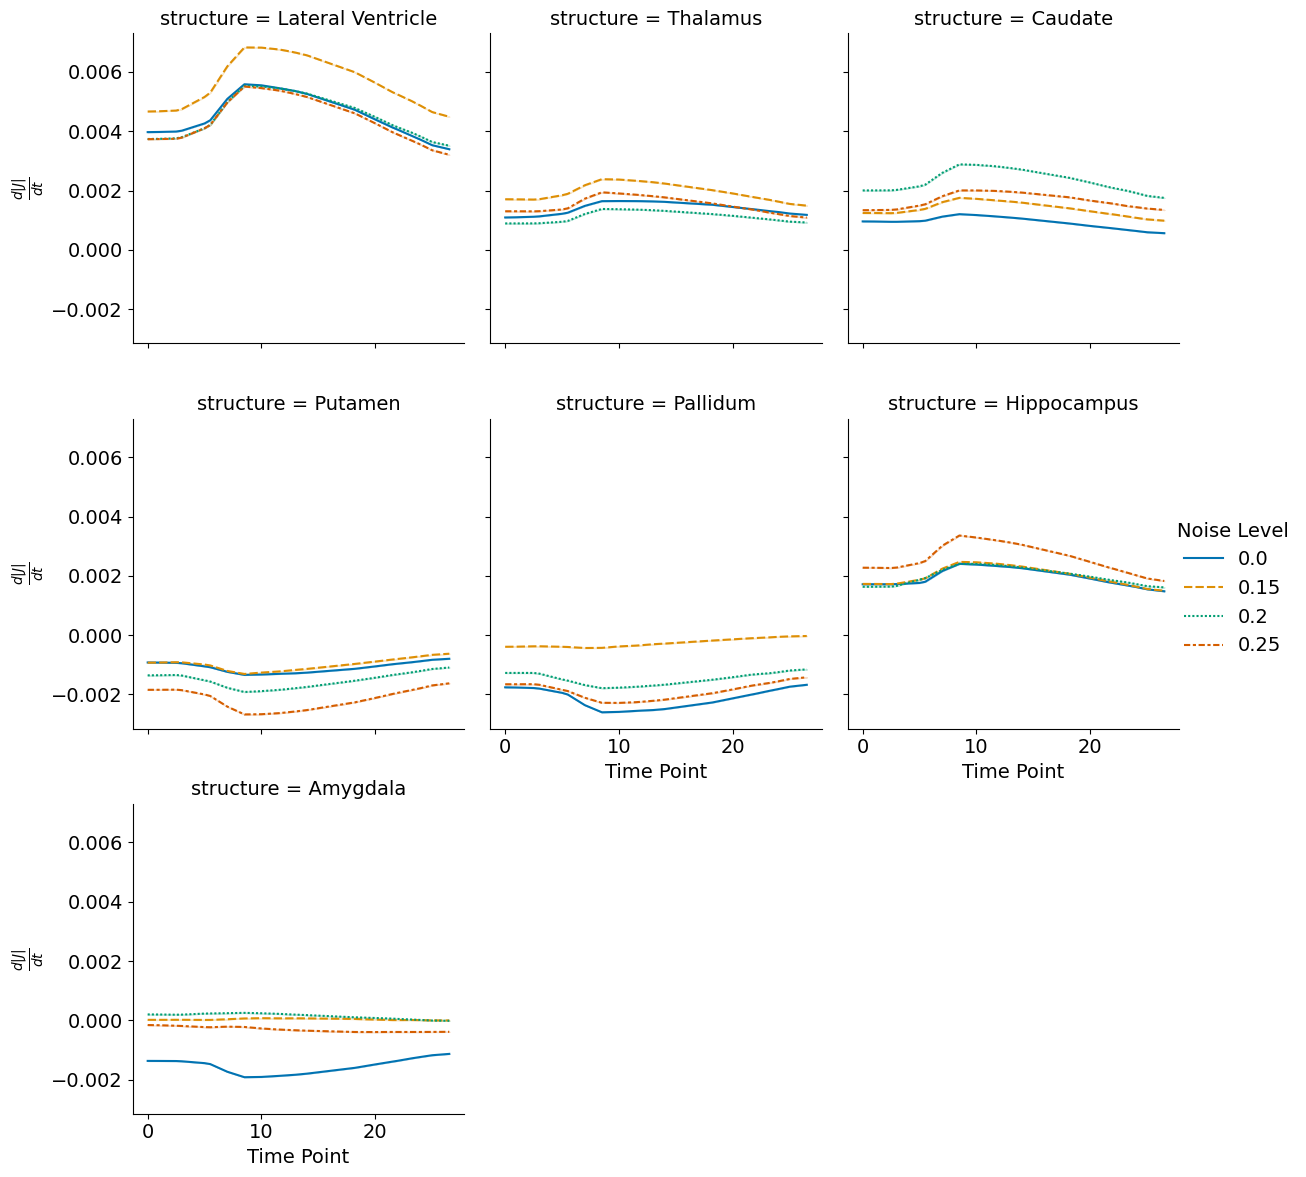

In [16]:
plt.rcParams.update({'font.size': 14}) 
g = sns.FacetGrid(df, col="structure", col_wrap=3, height=4, sharey=True)
g.map_dataframe(
    sns.lineplot, 
    x="time_point", 
    y="jac_det_derivative_mean", 
    hue="noise_level", 
    style="noise_level", 
    errorbar="sd",  
    palette="colorblind"
)

g.set_axis_labels("Time Point", r"$\frac{d|J|}{dt}$")
g.add_legend()
g._legend.set_title("Noise Level")

plt.show()


/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2

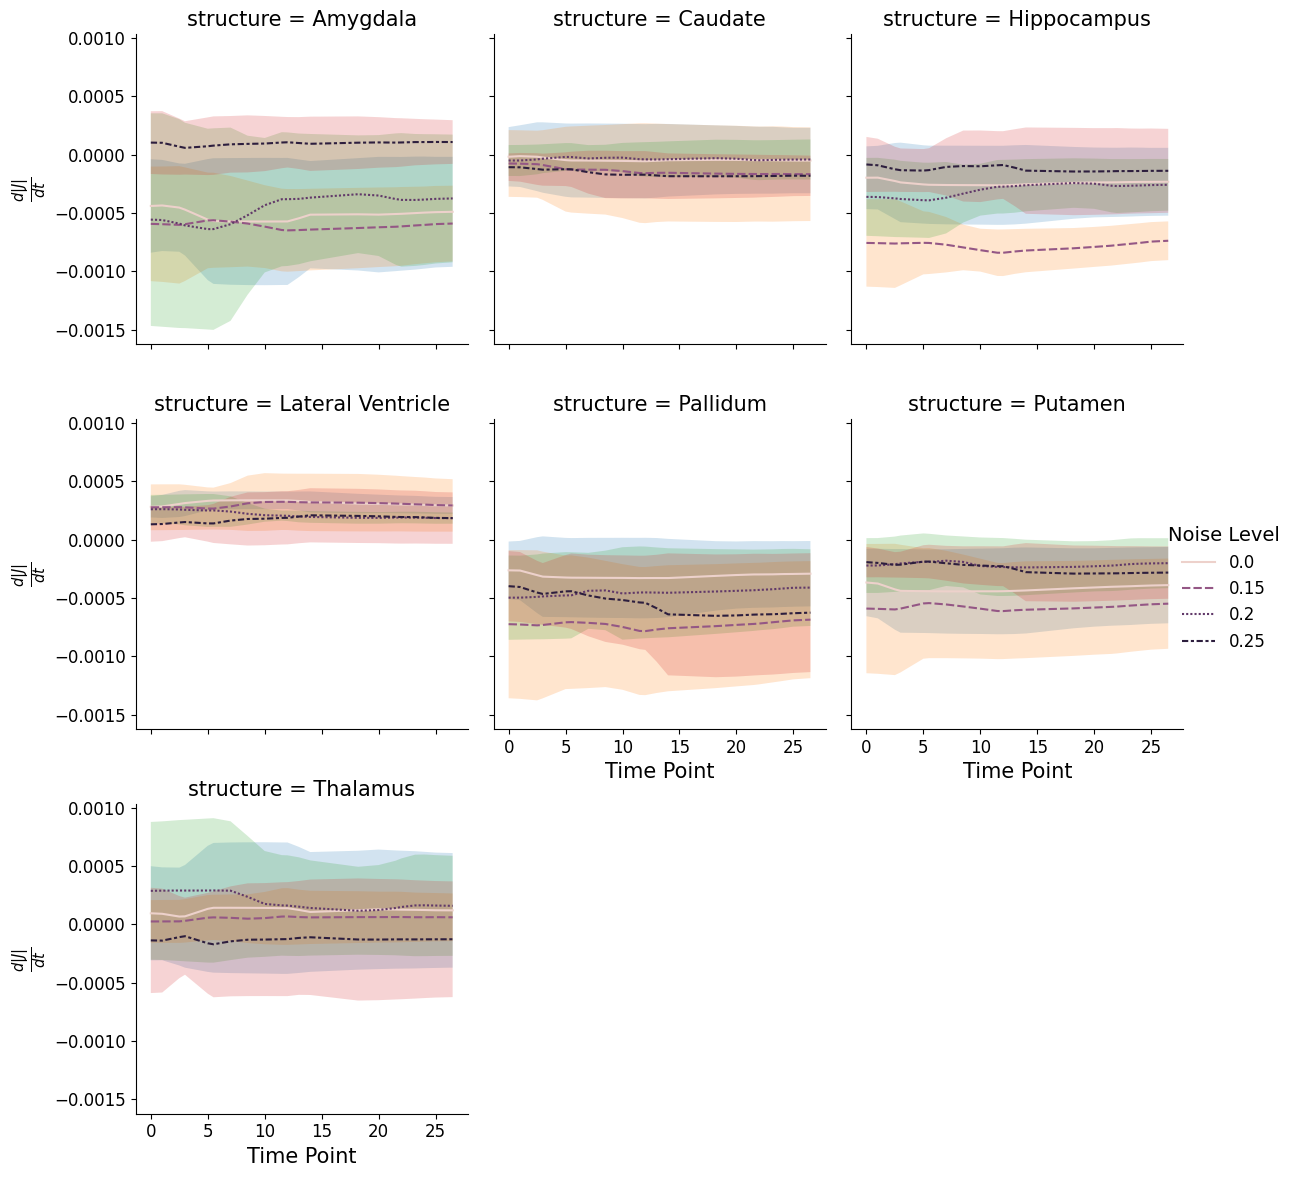

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2

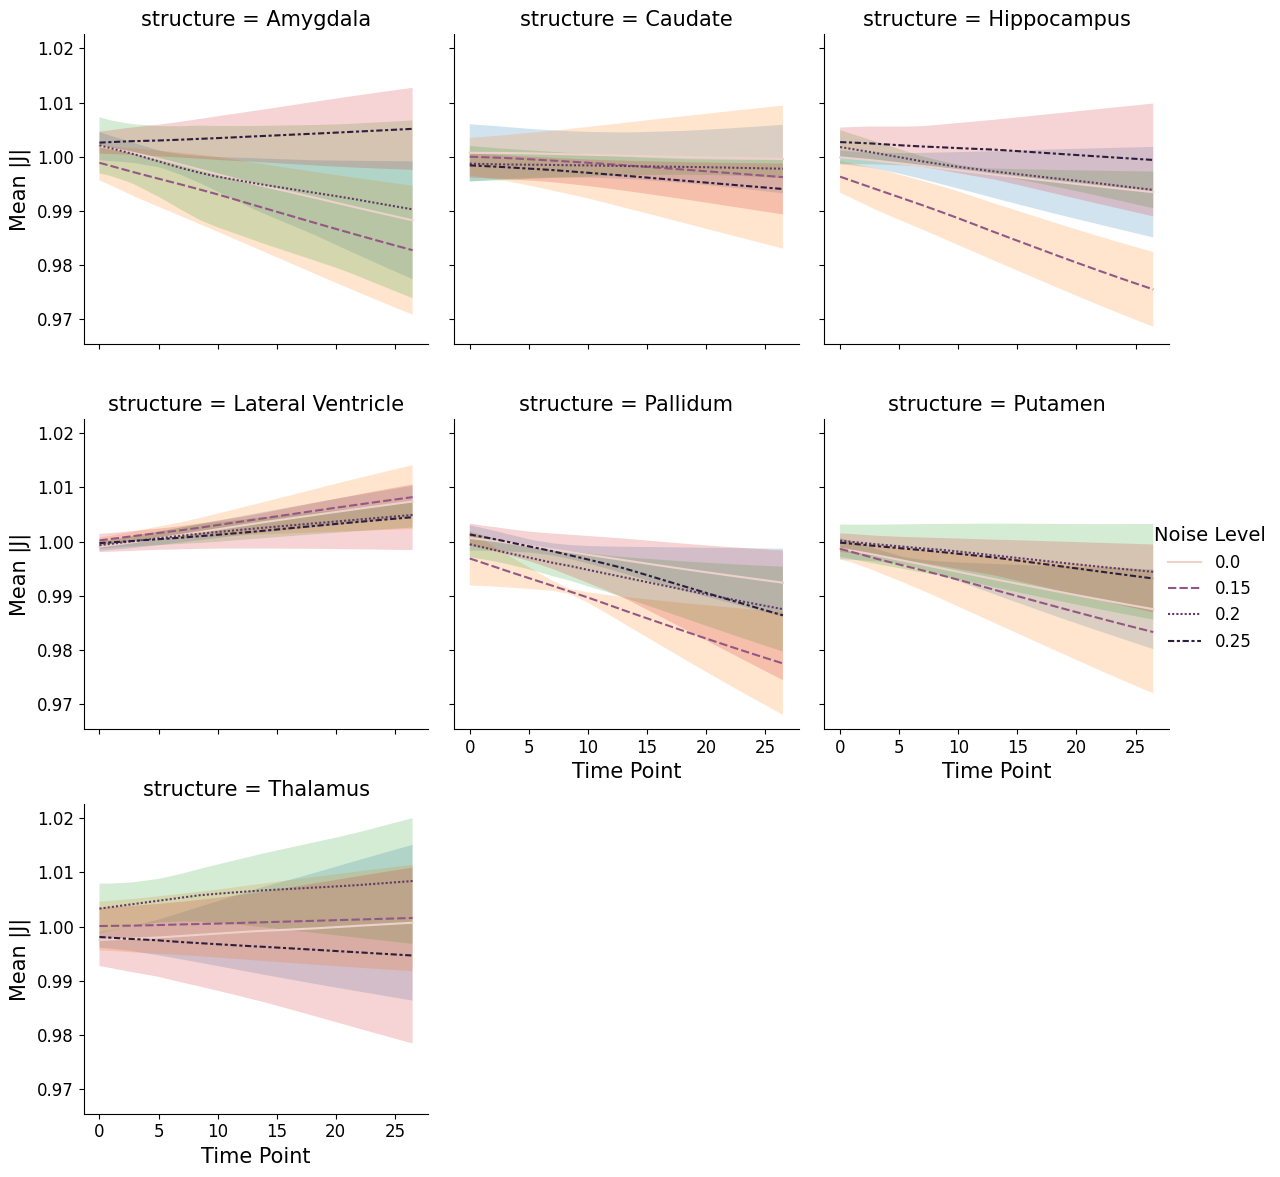

In [42]:
# df = pd.read_csv("jacobian_metrics_withmonoloss_final.csv")
df = pd.read_csv("jacobian_metrics_withmonoloss_mci.csv")

df_agg = df.groupby(["time_point", "noise_level", "structure"]).agg(
    jac_det_derivative_mean=("jac_det_derivative_mean", "mean"),
    jac_det_derivative_std=("jac_det_derivative_mean", "std"),
    jac_det_mean=("jac_det_mean", "mean"),
    jac_det_std=("jac_det_mean", "std")
).reset_index()

g = sns.FacetGrid(df_agg, col="structure", col_wrap=3, height=4, sharey=True)

def plot_with_std(data, **kwargs):
    ax = plt.gca()
    
    sns.lineplot(data=data, x="time_point", y="jac_det_derivative_mean", hue="noise_level", style="noise_level", ax=ax, **kwargs)
    
    for noise_level in data["noise_level"].unique():
        subset = data[data["noise_level"] == noise_level]
        ax.fill_between(
            subset["time_point"], 
            subset["jac_det_derivative_mean"] - subset["jac_det_derivative_std"],
            subset["jac_det_derivative_mean"] + subset["jac_det_derivative_std"],
            alpha=0.2
        )

g.map_dataframe(plot_with_std)

g.set_axis_labels("Time Point", r"$\frac{d|J|}{dt}$")
g.add_legend()
g._legend.set_title("Noise Level")

plt.show()


g = sns.FacetGrid(df_agg, col="structure", col_wrap=3, height=4, sharey=True)
def plot_with_std_jac_det(data, **kwargs):
    ax = plt.gca()
    sns.lineplot(data=data, x="time_point", y="jac_det_mean", hue="noise_level", style="noise_level", ax=ax, **kwargs)
    for noise_level in data["noise_level"].unique():
        subset = data[data["noise_level"] == noise_level]
        ax.fill_between(
            subset["time_point"], 
            subset["jac_det_mean"] - subset["jac_det_std"],
            subset["jac_det_mean"] + subset["jac_det_std"],
            alpha=0.2
        )

g.map_dataframe(plot_with_std_jac_det)

g.set_axis_labels("Time Point", "Mean |J|")
g.add_legend()
g._legend.set_title("Noise Level")

plt.show()


/tmp/ipykernel_117544/1892996655.py:30: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_117544/1892996655.py:30: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(
/its/home/as2614/.cache/pypoetry/virtual

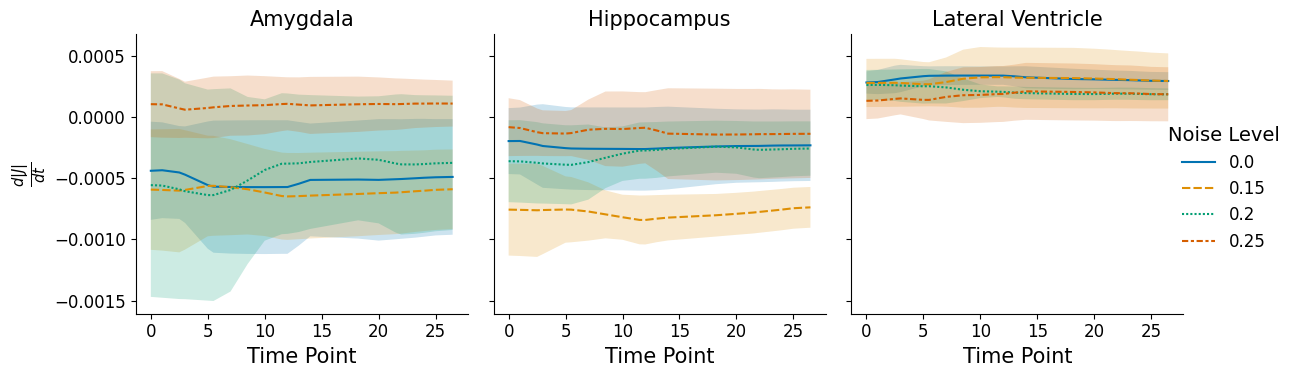

/tmp/ipykernel_117544/1892996655.py:57: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_117544/1892996655.py:57: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(
/its/home/as2614/.cache/pypoetry/virtual

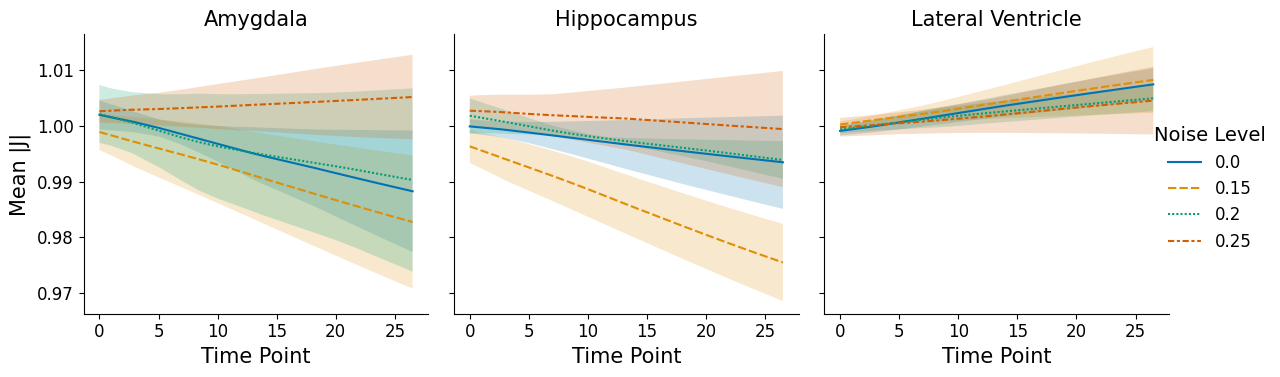

In [61]:
plt.rcParams.update({'font.size': 14}) 

df = pd.read_csv("jacobian_metrics_withmonoloss_mci.csv")

selected_structures = ["Lateral Ventricle", "Hippocampus", "Amygdala"]
df = df[df["structure"].isin(selected_structures)]
df_agg = df.groupby(["time_point", "noise_level", "structure"]).agg(
    jac_det_derivative_mean=("jac_det_derivative_mean", "mean"),
    jac_det_derivative_std=("jac_det_derivative_mean", "std"),
    jac_det_mean=("jac_det_mean", "mean"),
    jac_det_std=("jac_det_mean", "std")
).reset_index()
colorblind_palette = sns.color_palette("colorblind")

g = sns.FacetGrid(df_agg, col="structure", col_wrap=3, height=4, sharey=True)

def plot_with_std(data, **kwargs):
    ax = plt.gca()
    sns.lineplot(
        data=data, x="time_point", y="jac_det_derivative_mean", 
        hue="noise_level", style="noise_level", ax=ax, 
        palette=colorblind_palette, **kwargs  
    )
    for noise_level in data["noise_level"].unique():
        subset = data[data["noise_level"] == noise_level]
        ax.fill_between(
            subset["time_point"], 
            subset["jac_det_derivative_mean"] - subset["jac_det_derivative_std"],
            subset["jac_det_derivative_mean"] + subset["jac_det_derivative_std"],
            alpha=0.2
        )

g.map_dataframe(plot_with_std)
g.set_titles("{col_name}") 
g.set_axis_labels("Time Point", r"$\frac{d|J|}{dt}$")
g.add_legend()
g._legend.set_title("Noise Level")

plt.show()

g = sns.FacetGrid(df_agg, col="structure", col_wrap=3, height=4, sharey=True)

def plot_with_std_jac_det(data, **kwargs):
    ax = plt.gca()
    sns.lineplot(
        data=data, x="time_point", y="jac_det_mean", 
        hue="noise_level", style="noise_level", ax=ax, 
        palette=colorblind_palette, **kwargs 
    )
    for noise_level in data["noise_level"].unique():
        subset = data[data["noise_level"] == noise_level]
        ax.fill_between(
            subset["time_point"], 
            subset["jac_det_mean"] - subset["jac_det_std"],
            subset["jac_det_mean"] + subset["jac_det_std"],
            alpha=0.2
        )

g.map_dataframe(plot_with_std_jac_det)
g.set_titles("{col_name}") 
g.set_axis_labels("Time Point", "Mean |J|")
g.add_legend()
g._legend.set_title("Noise Level")

plt.show()


/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


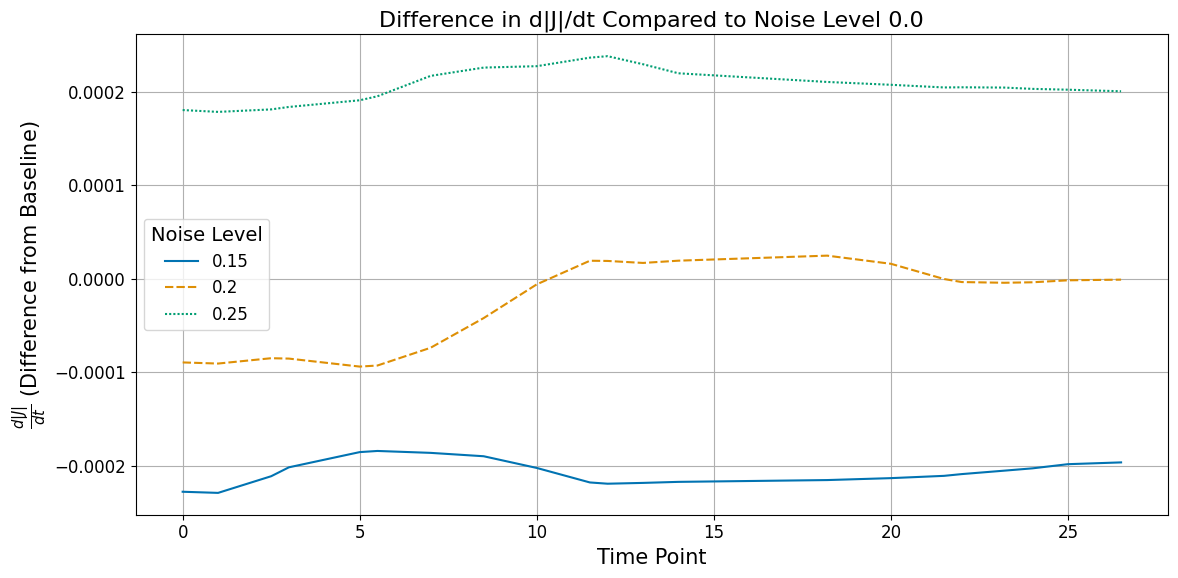

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2

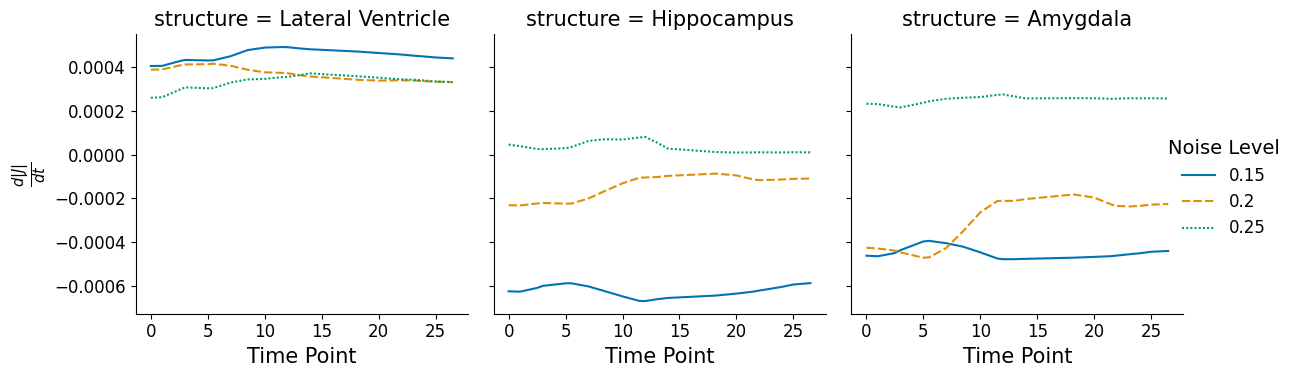

In [51]:
df = pd.read_csv("jacobian_metrics_withmonoloss_mci.csv")
df["time_point"] = pd.to_numeric(df["time_point"])
baseline_df = df[df["noise_level"] == 0.0][["time_point", "jac_det_derivative_mean"]].rename(
    columns={"jac_det_derivative_mean": "baseline_jac_det_derivative_mean"}
)
df = df.merge(baseline_df, on="time_point", how="left")
#im unable to plot x axis so just filter for now
structures_to_plot = ["Hippocampus", "Lateral Ventricle", "Amygdala"]
df = df[df["structure"].isin(structures_to_plot)]
df["delta_jac_det_derivative_mean"] = df["jac_det_derivative_mean"] - df["baseline_jac_det_derivative_mean"]

df = df[(df["noise_level"] != 0.0) & (df["noise_level"] != 0.1)]


plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 14}) 
sns.lineplot(
    data=df,
    x="time_point",
    y="delta_jac_det_derivative_mean",
    hue="noise_level",
    style="noise_level",
    markers=False,
    # errorbar='sd',
    errorbar=None,
    palette="colorblind"
)

plt.xlabel("Time Point")
plt.ylabel(r"$\frac{d|J|}{dt}$ (Difference from Baseline)")
plt.title("Difference in d|J|/dt Compared to Noise Level 0.0")
plt.legend(title="Noise Level")
plt.grid(True)
plt.tight_layout()

plt.show()

#facetgrid
g = sns.FacetGrid(df, col="structure", col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x="time_point", y="delta_jac_det_derivative_mean", hue="noise_level", style="noise_level", markers=False, errorbar=None, palette="colorblind")
g.set_axis_labels("Time Point", r"$\frac{d|J|}{dt}$")

g.add_legend()
g._legend.set_title("Noise Level")

plt.show()


/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2

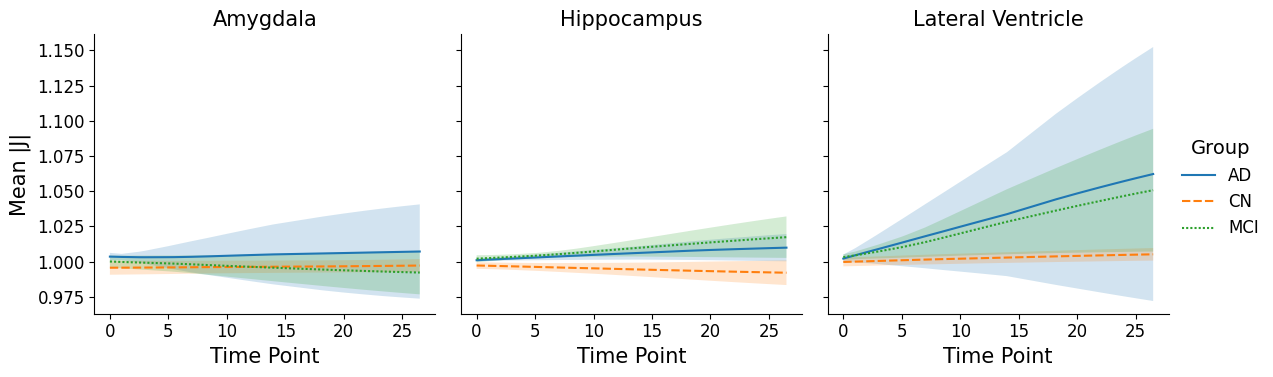

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/its/home/as2

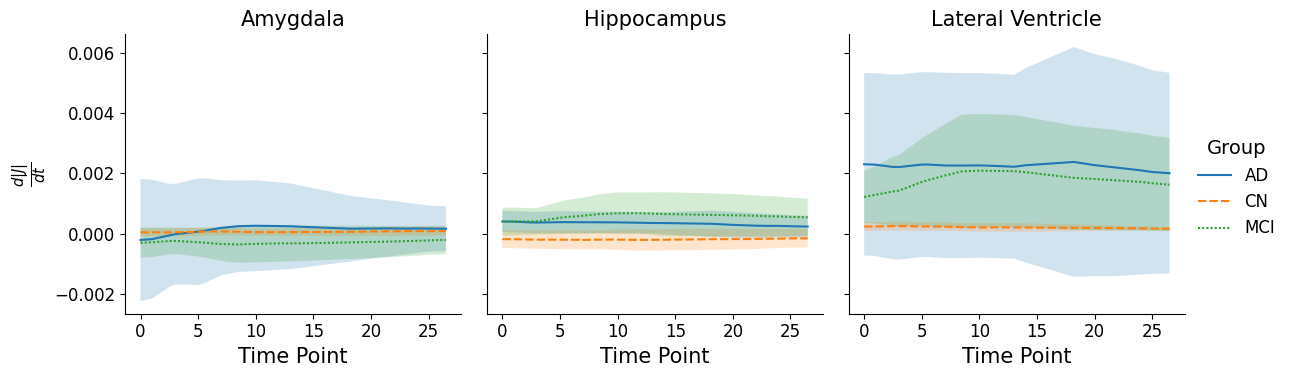

In [46]:
df = pd.read_csv("group_jacobian_metrics_final.csv")
structures_to_plot = ["Amygdala", "Hippocampus", "Lateral Ventricle"]
df = df[df["structure"].isin(structures_to_plot)]
df_agg = df.groupby(["time_point", "structure", "group"]).agg(
    jac_det_mean=("jac_det_mean", "mean"),
    jac_det_mean_std=("jac_det_mean", "std"),
    jac_det_derivative_mean=("jac_det_derivative_mean", "mean"),
    jac_det_derivative_std=("jac_det_derivative_mean", "std")
).reset_index()
def plot_with_std(data, x, y, y_std, ylabel):
    """Helper function to plot mean with standard deviation shading."""
    g = sns.FacetGrid(data, col="structure", col_wrap=3, height=4, sharey=True)

    def plot_lines(sub_data, **kwargs):
        ax = plt.gca()
        sns.lineplot(data=sub_data, x=x, y=y, hue="group", style="group", ax=ax, **kwargs)
        
        for group in sub_data["group"].unique():
            subset = sub_data[sub_data["group"] == group]
            ax.fill_between(
                subset[x],
                subset[y] - subset[y_std],
                subset[y] + subset[y_std],
                alpha=0.2
            )

    g.map_dataframe(lambda data, **kwargs: plot_lines(data, **kwargs))

    g.set_axis_labels("Time Point", ylabel)
    g.set_titles("{col_name}") 
    g.add_legend()
    g._legend.set_title("Group")
    plt.show()
plot_with_std(df_agg, x="time_point", y="jac_det_mean", y_std="jac_det_mean_std", ylabel="Mean |J|")
plot_with_std(df_agg, x="time_point", y="jac_det_derivative_mean", y_std="jac_det_derivative_std", ylabel=r"$\frac{d|J|}{dt}$")

